In [1]:
import bambi as bmb
import pandas as pd
import numpy as np
import pymc3 as pm
import pymc3.diagnostics as pmd
import pylab
import seaborn as sns
%matplotlib inline

//anaconda/envs/python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load and examine Eugene-Springfield community sample data

In [2]:
data = pd.read_csv('data/ESCS.csv')
np.round(data.describe(), 2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


It's always a good idea to start off with some basic plotting. Here's what our outcome variable 'drugs' (some index of self-reported illegal drug use) looks like:

//anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


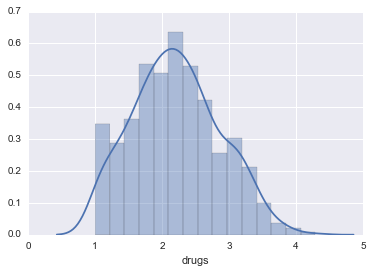

In [3]:
sns.distplot(data['drugs'])

The five predictor variables that we'll use are sum-scores measuring participants' standings on the Big Five personality dimensions. The dimensions are:
- O = Openness to experience
- C = Conscientiousness
- E = Extraversion
- A = Agreeableness
- N = Neuroticism

Here's what our predictors look like:

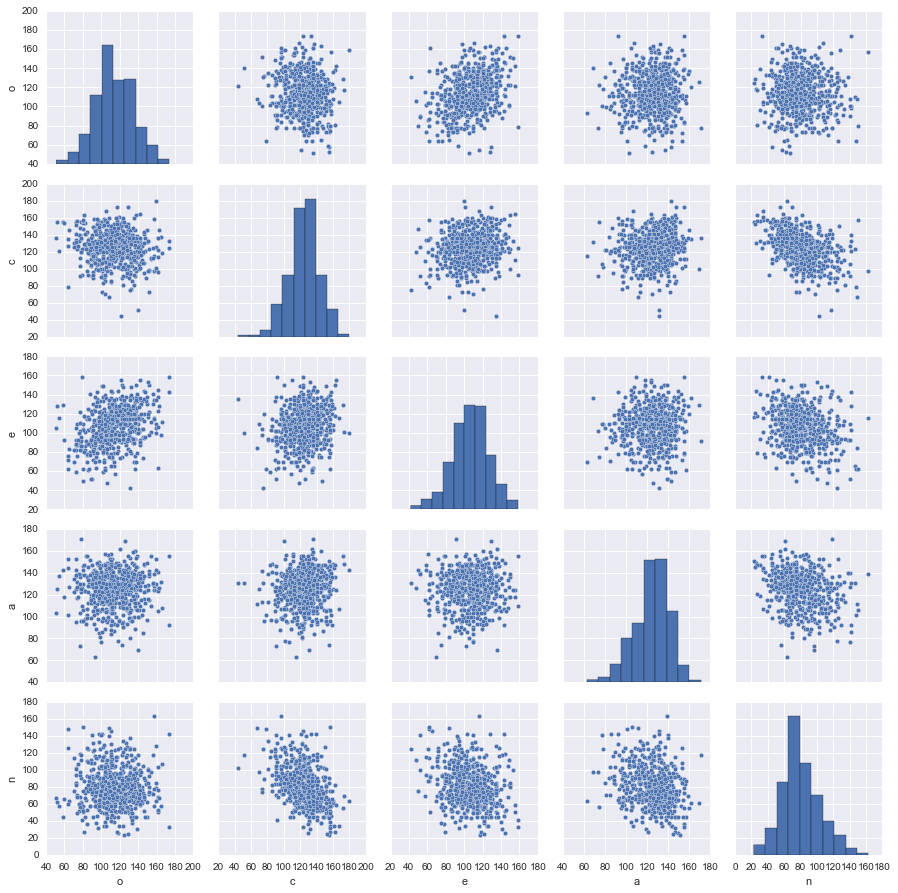

In [7]:
sns.pairplot(data[['o','c','e','a','n']])

# Specify model and examine priors

We're going to fit a pretty straightforward multiple regression model predicting drug use from all 5 personality dimension scores. It's simple to specify the model using a familiar formula interface. Here we tell bambi to run two parallel Markov Chain Monte Carlo (MCMC) chains, each one drawing 2000 samples from the joint posterior distribution of all the parameters.

In [5]:
model = bmb.Model(data)
fitted = model.fit('drugs ~ o + c + e + a + n', samples=2000, njobs=2)

Applied interval-transform to drugs_sd and added transformed drugs_sd_interval to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_o
Assigned NUTS to b_c
Assigned NUTS to b_e
Assigned NUTS to b_a
Assigned NUTS to b_n
Assigned NUTS to drugs_sd_interval


/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:221: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  warnings.warn("Current Bayesian model has not been built yet; "


 [-----------------100%-----------------] 2000 of 2000 complete in 61.1 sec

Great! But this is a Bayesian model, right? What about the priors?

If no priors are given explicitly by the user, then bambi chooses smart default priors for all parameters of the model based on the implied partial correlations between the outcome and the predictors. Here's what the default priors look like in this case -- the plots below show 1000 draws from each prior distribution:

Applied interval-transform to drugs_sd and added transformed drugs_sd_interval to model.


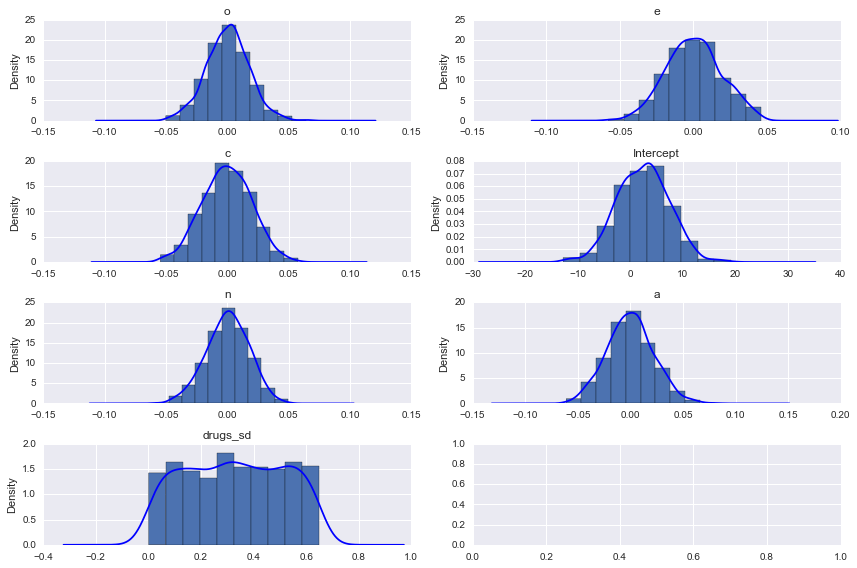

In [42]:
_ = model.plot()

In [8]:
# Normal priors on the coefficients
{x.name:x.prior.args for x in model.terms.values()}

{'Intercept': {'mu': 2.2101466414380631, 'sd': 4.9335157200332338},
 'a': {'mu': 0, 'sd': array([[ 0.02209112]])},
 'c': {'mu': 0, 'sd': array([[ 0.02084506]])},
 'e': {'mu': 0, 'sd': array([[ 0.01903547]])},
 'n': {'mu': 0, 'sd': array([[ 0.01690199]])},
 'o': {'mu': 0, 'sd': array([[ 0.01780879]])}}

In [12]:
# Uniform prior on the residual standard deviation
model.y.prior.args['sd'].args

{'lower': 0, 'upper': 0.64877877481895585}

Notice the small SDs of the slope priors. This is due to the relative scales of the outcome and the predictors: remember from the plots above that the outcome, `drugs`, ranges from 1 to about 4, while the predictors all range from about 20 to 180 or so. So a one-unit change in any of the predictors -- which is a trivial increase on the scale of the predictors -- is likely to lead to a very small absolute change in the outcome. Believe it or not, these priors are actually quite wide on the partial correlation scale!

# Examine the model results

Let's start with a pretty picture of the parameter estimates! Setting the `burn_in` parameter to 50 instructs bambi to discard the first 50 samples from both chains, which tend to be unstable.

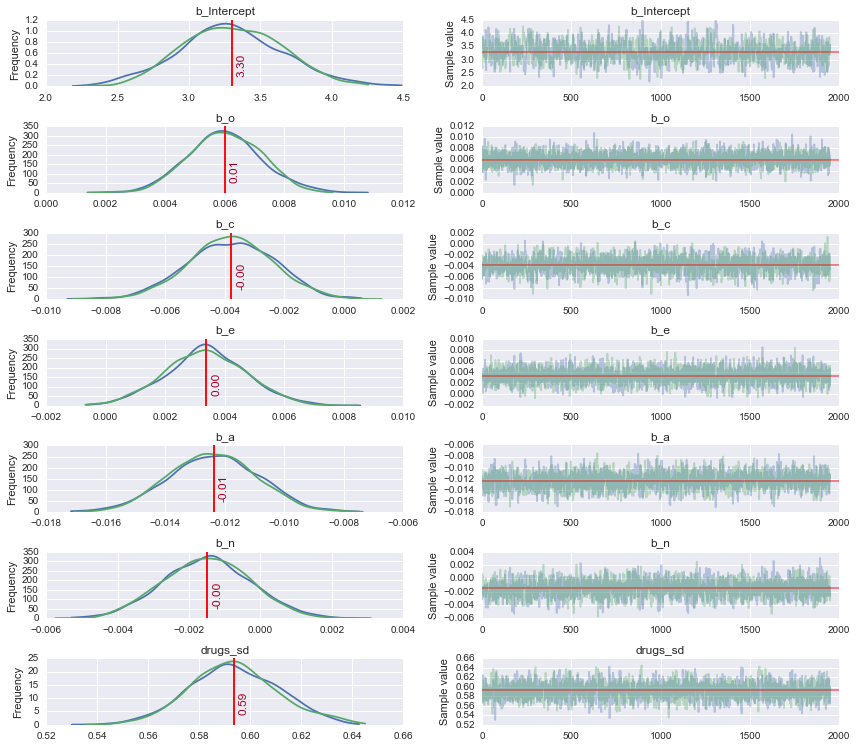

In [14]:
_ = fitted.plot(burn_in=50)

The left panels show the marginal posterior distributions for all of the model’s parameters, which summarize the most plausible values of the regression coefficients, given the data we have now observed. The lines and annotations indicate the means of the posteriors, which are reasonable point estimates of the parameters, although there is not necessarily any need to reduce these distributions to single point estimates. These posterior density plots show two overlaid distributions because we ran two MCMC chains. The panels on the right are "trace plots" showing the sampling paths of the two MCMC chains as they wander through the parameter space. 

A much more succinct (non-graphical) summary of the parameter estimates can be found like so:

In [39]:
fitted.summary(burn_in=50)

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,3.300774,0.356465,0.011940,2.576682,3.972709
o,0.006007,0.001223,0.000023,0.003593,0.008274
c,-0.003788,0.001441,0.000036,-0.006545,-0.001060
e,0.003373,0.001357,0.000028,0.000693,0.006006
a,-0.012379,0.001484,0.000035,-0.015173,-0.009538
n,-0.001496,0.001218,0.000028,-0.003853,0.000821
drugs_sd,0.593720,0.017451,0.000467,0.559373,0.628738


# Diagnostics

It's pretty clear from the trace plots above that the chains have converged just fine, but for illustration's sake, here we get some basic diagnostic info using some of the diagnostic tools built into the PyMC3 package.

The effective numbers of independent samples for each parameter are:

In [16]:
pmd.effective_n(fitted.trace[50:])

{'b_Intercept': [802],
 'b_a': [1490],
 'b_c': [1301],
 'b_e': [2193],
 'b_n': [1665],
 'b_o': [2532],
 'drugs_sd': 1282,
 'drugs_sd_interval': 924}

And the Gelman-Rubin statistics (we want these to be close to 1) for each parameter are:

In [17]:
pmd.gelman_rubin(fitted.trace[50:])

{'b_Intercept': array(1.0000819986697744),
 'b_a': array(1.0000431901147966),
 'b_c': array(0.9997468485421889),
 'b_e': array(1.0001531323924564),
 'b_n': array(0.9998504842620126),
 'b_o': array(0.9997829640541315),
 'drugs_sd': 0.99975206813048179,
 'drugs_sd_interval': 0.99983499385257513}

# Summarize effects on partial correlation scale

Let's grab the samples and put them in a format where we can easily work with them. We can do this really easily using the `get_trace()` method of the fitted `ModelResults` object. 

In [37]:
traces = fitted.get_trace(burn_in=50)
traces.head()

,b_Intercept,b_o,b_c,b_e,b_a,b_n,drugs_sd
0,3.428151,0.008383,-0.006421,0.003197,-0.012367,-0.002504,0.578703
1,3.704762,0.003757,-0.003465,0.002117,-0.011514,-0.003157,0.585864
2,3.588836,0.007866,-0.003641,0.001796,-0.015018,-0.001587,0.602172
3,3.779410,0.005673,-0.004763,0.002041,-0.012769,-0.002877,0.606232
4,3.759800,0.005435,-0.004865,0.002330,-0.012949,-0.002618,0.606915


It turns out that we can convert each regresson coefficient into a partial correlation by multiplying it by a constant that depends on (1) the SD of the predictor, (2) the SD of the outcome, and (3) the degree of multicollinearity with the set of other predictors. It further turns out that we already compute and store all the needed statistics in the fitted model object, in a dictionary called `dm_statistics` (for design matrix statistics)!

In [23]:
slope_constant = model.dm_statistics['sd_x'] * (1 - model.dm_statistics['r2_x'])**.5 / \
    model.dm_statistics['sd_y'] / (1 - model.dm_statistics['r2_y'])**.5
slope_constant

a    26.134943
c    27.697221
e    30.330235
n    34.158720
o    32.419405
dtype: float64

Now we just multiply each sampled regression coefficient by its corresponding `slope_constant` to transform it into a sampled partial correlation coefficient.

In [38]:
varnames = ['o','c','e','a','n']
pcorr_traces = pd.DataFrame({x: traces['b_'+x] * slope_constant[x] for x in varnames})
pcorr_traces.head()

,a,c,e,n,o
0,-0.323210,-0.177842,0.096976,-0.085550,0.271788
1,-0.300906,-0.095983,0.064198,-0.107830,0.121804
2,-0.392499,-0.100854,0.054461,-0.054222,0.255020
3,-0.333720,-0.131926,0.061912,-0.098285,0.183923
4,-0.338422,-0.134751,0.070661,-0.089411,0.176197


And voilà! We now have a joint posterior distribution for the partial correlation coefficients. Let's plot the marginal posterior distributions:

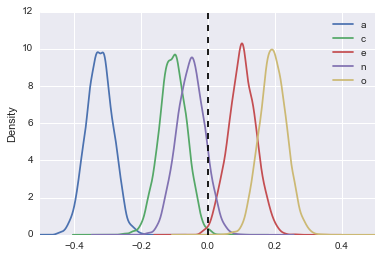

In [30]:
pcorr_traces.plot.kde(xlim=[-.5,.5]).axvline(x=0, color='k', linestyle='--')

The means of these distributions serve as good point estimates of the partial correlations:

In [31]:
pcorr_traces.mean(axis=0).sort_values()

a   -0.323533
c   -0.104929
n   -0.051085
e    0.102303
o    0.194733
dtype: float64

Naturally, these results are consistent with the OLS results. For example, we can see that these estimated partial correlations are roughly proportional to the t-statistics from the corresponding OLS regression:

In [32]:
pd.stats.api.ols(y=data['drugs'], x=data[['o','c','e','a','n']])


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <o> + <c> + <e> + <a> + <n> + <intercept>

Number of Observations:         604
Number of Degrees of Freedom:   6

R-squared:         0.1760
Adj R-squared:     0.1691

Rmse:              0.5914

F-stat (5, 598):    25.5432, p-value:     0.0000

Degrees of Freedom: model 5, resid 598

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             o     0.0061     0.0012       4.89     0.0000     0.0036     0.0085
             c    -0.0038     0.0015      -2.59     0.0098    -0.0067    -0.0009
             e     0.0034     0.0013       2.52     0.0120     0.0007     0.0060
             a    -0.0124     0.0015      -8.39     0.0000    -0.0153    -0.0095
             n    -0.0015     0.0012      -1.27     0

# Relative importance: Which predictors have the strongest effects (defined in terms of partial $\eta^2$)?

The partial $\eta^2$ statistics for each predictor are just the squares of the partial correlation coefficients, so it's easy to get posteriors on that scale too:

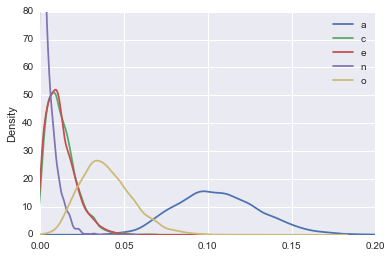

In [33]:
(pcorr_traces**2).plot.kde(xlim=[0,.2], ylim=[0,80])

With these posteriors we can ask: What is the probability that the partial $\eta^2$ for Openness (yellow) is greater than the partial $\eta^2$ for Conscientiousness (green)?

In [34]:
(pcorr_traces['o']**2 > pcorr_traces['c']**2).mean()

0.92897435897435898

For each predictor, what is the probability that it has the largest $\eta^2$?

In [35]:
(pcorr_traces**2).idxmax(axis=1).value_counts() / len(pcorr_traces.index)

a    0.991026
o    0.008718
c    0.000256
dtype: float64

Agreeableness is clearly the strongest predictor of drug use among the Big Five personality traits, but it's still not a particularly strong predictor in an absolute sense. Walter Mischel famously claimed that it is rare to see correlations between personality measurse and relevant behavioral outcomes exceed 0.3. In this case, the probability that the agreeableness partial correlation exceeds 0.3 is:

In [43]:
(np.abs(pcorr_traces['a']) > .3).mean()

0.72820512820512817